In [251]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import scipy
from scipy.sparse import csc_matrix
from collections import defaultdict
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
with open('./../PickleFiles/num_to_ind_shot.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

with open('./../PickleFiles/ind_to_num_shot.pkl','r') as pickleFile:
    ind_to_num = pickle.load(pickleFile)
    
with open('./../PickleFiles/player_names.pkl','r') as pickleFile:
    num_to_name = pickle.load(pickleFile)

name_to_num = {value:key for key,value in num_to_name.iteritems()}

Selecting most predictive for first 100 tournament groups

In [278]:
mypath = './../ranks/'
corrs = defaultdict(list)
for path in [f for f in listdir(mypath)]:
    if len([f for f in listdir(mypath+path)])!=28:
        continue
    ratings_adam = {}
    for cat in cats:
        ratings_adam[cat] = np.load('%s%s/%s_ranks.npy' % (mypath,path,cat))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group==0 or tournament_group>99:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_adam[cat][players,tournament_group-1]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([np.corrcoef(preds[cat],outcomes[cat])[0,1]])
print corrs

In [265]:
mypath = './../Broadie_Aves/'
corrs = defaultdict(list)
for BETA in range(1,10):
    ratings_broadie = {}
    for cat in cats:
        ratings_broadie[cat] = np.load('%s/%s_%d.npy' % (mypath,cat,BETA))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group==0 or tournament_group>99:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_broadie[cat][players,tournament_group]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([np.corrcoef(preds[cat],outcomes[cat])[0,1]])
print corrs

In [199]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

In [203]:
ratings_adam = {}
for cat in cats:
    ratings_adam[cat] = np.load('./../ranks/ranks-300-0.23-0.15-0.7-0.9-5/%s_ranks.npy' % cat)

In [204]:
ratings_broadie = {}
for cat in cats:
    ratings_broadie[cat] = np.load('./../Broadie_Aves/%s_9.npy' % cat)

In [182]:
e = np.load('./../ranks/ranks-300-0.23-0.15-0.7-0.9-5/tee45_ranks.npy')

In [183]:
e = pd.DataFrame(e).rank(pct=True,axis=0).values

In [184]:
b = np.load('./../Broadie_Aves/tee45_8.npy')

In [185]:
b = pd.DataFrame(b).rank(pct=True,axis=0).values

In [186]:
num_to_ind[name_to_num['Mickelson, Phil']]

94

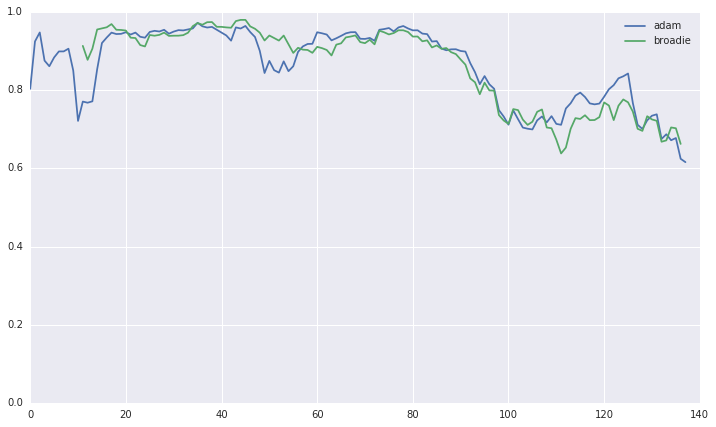

In [193]:
plt.figure(figsize=(12,7))
plt.plot(e[94,:],label='adam')
plt.plot(b[94,:][1:],label='broadie');
plt.legend();
plt.ylim(0,1);

In [156]:
rdata = pd.read_csv('./../data/round.csv')

In [173]:
cols = ['Year','Permanent_Tournament_#']
data = pd.concat([pd.read_csv('./../data/%d.csv' % (year))[cols] for year in range(2003,2017)])

In [189]:
tups = data.drop_duplicates(['Year','Permanent_Tournament_#'])[['Year','Permanent_Tournament_#']].values.tolist()
tournament_groups = {tuple(tup):u/4 for u,tup in enumerate(tups)}

In [228]:
preds_a,preds_b,outcomes = defaultdict(list),defaultdict(list),defaultdict(list)
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group==0:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = [num_to_ind[player] for player in players]
    for cat in cats:
        ratings_a = ratings_adam[cat][players,tournament_group-1]
        ratings_b = ratings_broadie[cat][players,tournament_group]
        nulls = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
        if np.all(nulls):
            continue
        rankings_a = pd.Series(ratings_a[~nulls]).rank(ascending=False,pct=True)
        rankings_b = pd.Series(ratings_b[~nulls]).rank(ascending=False,pct=True)
        outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
        preds_a[cat].extend(rankings_a.tolist())
        preds_b[cat].extend(rankings_b.tolist())
        outcomes[cat].extend(outcome.tolist())

In [252]:
corrs = {cat:np.corrcoef(preds_b[cat],outcomes[cat])[0,1] for cat in cats}

In [253]:
for cat in sorted(corrs,key=corrs.get,reverse=True):
    print cat,corrs[cat]

fairway540 0.106543100993
green0 0.106400183893
fairway300 0.106396113129
green20 0.106388637976
tee3 0.106386786081
green10 0.106378375975
tee45 0.106315785842
green5 0.10625266043
fairway0 0.106228283209
rough375 0.106223923653
rough90 0.106010228826
bunker 0.105796155853
rough0 0.10572738815
other 0.0996013334742


In [236]:
for cat in cats:
    print
    print cat
    print 'Adam Corr = ' + str(np.corrcoef(preds_a[cat],outcomes[cat])[0,1])
    print 'Broadie Corr = ' + str(np.corrcoef(preds_b[cat],outcomes[cat])[0,1])
    print 


tee3
Adam Corr = 0.10837570791
Broadie Corr = 0.106386786081


tee45
Adam Corr = 0.116037126701
Broadie Corr = 0.106315785842


green0
Adam Corr = 0.0517925734532
Broadie Corr = 0.106400183893


green5
Adam Corr = 0.0456228457348
Broadie Corr = 0.10625266043


green10
Adam Corr = 0.0546399791154
Broadie Corr = 0.106378375975


green20
Adam Corr = 0.053486057197
Broadie Corr = 0.106388637976


rough0
Adam Corr = 0.0591602527828
Broadie Corr = 0.10572738815


rough90
Adam Corr = 0.0505111845911
Broadie Corr = 0.106010228826


rough375
Adam Corr = 0.084667474203
Broadie Corr = 0.106223923653


fairway0
Adam Corr = 0.078864620082
Broadie Corr = 0.106228283209


fairway300
Adam Corr = 0.101404402022
Broadie Corr = 0.106396113129


fairway540
Adam Corr = 0.0961272722674
Broadie Corr = 0.106543100993


bunker
Adam Corr = 0.0613018804446
Broadie Corr = 0.105796155853


other
Adam Corr = 0.0185318250727
Broadie Corr = 0.0996013334742

